## The Mystery of being broke by month end

## ReadME

This notebook utilises the *config_bank.yml* file to store a lot of hardcoded variables. Refer to the *config_bank.yml* for making any changes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from yaml import safe_load
from warnings import filterwarnings

filterwarnings('ignore')

CUSTOM FUNCTIONS

In [2]:
with open("config_bank.yml",'r') as f:
    config = safe_load(f)
    
date_cols = config.get('date_columns')
upi_platforms = config.get('upi_platform')
months = config.get("months")
expense_cols = config.get("expense_columns")


In [3]:
def detect_transaction(remark):
        
    patterns = config['pattern']
        
    for k,v in patterns.items():
        try:
            match=  re.search(v,remark)
            if match:
                return k
        except Exception as e:
            pass
    return None

def get_upi_platform(remark):    
    
    for k,v in upi_platforms.items():
        try:
            match=  re.search(k,remark)
            if match:
                return v
        except Exception as e:
            print(remark)
    return None   


In [4]:
data = pd.read_excel("data.xlsx",sheet_name="Sheet1")
data = data.drop(["S No."],axis=1)
data.head()

,Value Date,Transaction Date,Transaction Remarks,Withdrawal Amount,Deposit Amount,Balance
0,01/04/2021,02/04/2021,UPI/109109474229/test/jayantighosh66@/Punjab N...,1.0,0.0,288408.34
1,01/04/2021,02/04/2021,UPI/109143328898/Oid202104010910/paytm-2354160...,176.0,0.0,288232.34
2,02/04/2021,02/04/2021,BIL/BPAY/000081957525/SBI MUTUAL/SBDIRECT-5965...,4000.0,0.0,284232.34
3,02/04/2021,02/04/2021,BIL/BPAY/000081964632/AXIS MUTUA/AXDIRECT-E144...,3000.0,0.0,281232.34
4,02/04/2021,02/04/2021,UPI/109272170475/Oid13163152716@/paybil3066@pa...,49.0,0.0,281183.34


### Feature Engineering

In [5]:
# Convert to datetime.
date_cols = ["Value Date","Transaction Date"]
data[date_cols] = data[date_cols].apply(pd.to_datetime, format='%d/%m/%Y')

## New Columns:
tnx_date = config.get("tnx_date")

# Get Day and Month
data["Day"] = data[tnx_date].dt.strftime('%d')
data["Month"] = data[tnx_date].dt.month_name()

# Transaction Type
data["tnx_type"] = data["Transaction Remarks"].apply(detect_transaction)

# UPI platform
data["upi_platform"] = data["Transaction Remarks"].apply(get_upi_platform)
data.head()

,Value Date,Transaction Date,Transaction Remarks,Withdrawal Amount,Deposit Amount,Balance,Day,Month,tnx_type,upi_platform
0,2021-04-01,2021-04-02,UPI/109109474229/test/jayantighosh66@/Punjab N...,1.0,0.0,288408.34,02,April,UPI,None
1,2021-04-01,2021-04-02,UPI/109143328898/Oid202104010910/paytm-2354160...,176.0,0.0,288232.34,02,April,UPI,Paytm
2,2021-04-02,2021-04-02,BIL/BPAY/000081957525/SBI MUTUAL/SBDIRECT-5965...,4000.0,0.0,284232.34,02,April,External MF,None
3,2021-04-02,2021-04-02,BIL/BPAY/000081964632/AXIS MUTUA/AXDIRECT-E144...,3000.0,0.0,281232.34,02,April,External MF,None
4,2021-04-02,2021-04-02,UPI/109272170475/Oid13163152716@/paybil3066@pa...,49.0,0.0,281183.34,02,April,UPI,Paytm


### Usage of UPI Platforms

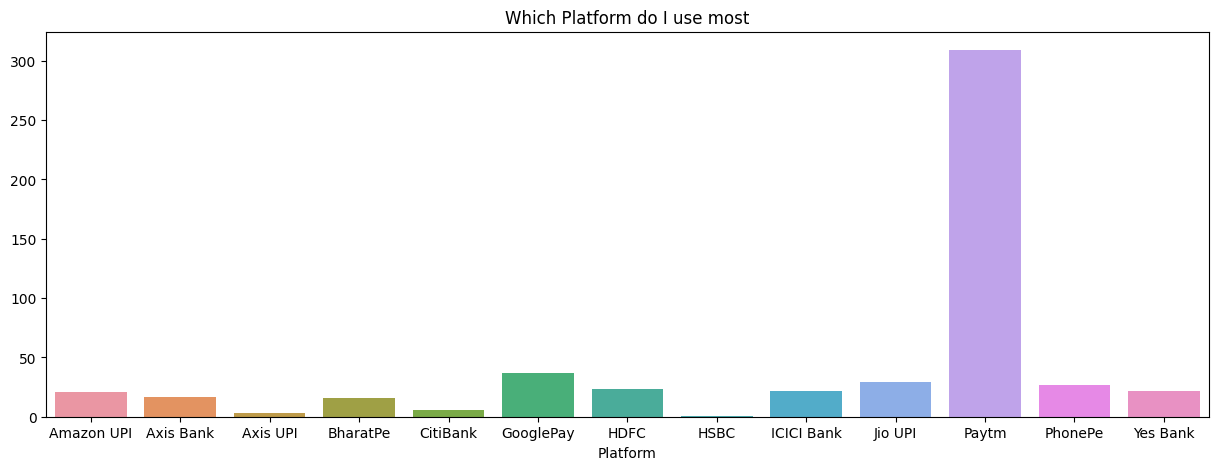

In [6]:
platforms = sorted(list(set(upi_platforms.values())))

plt.figure(figsize=(15,5))
sns.countplot(x=data["upi_platform"],order=platforms)
plt.title("Which Platform do I use most")
plt.ylabel("")
plt.xlabel("Platform")
plt.show();

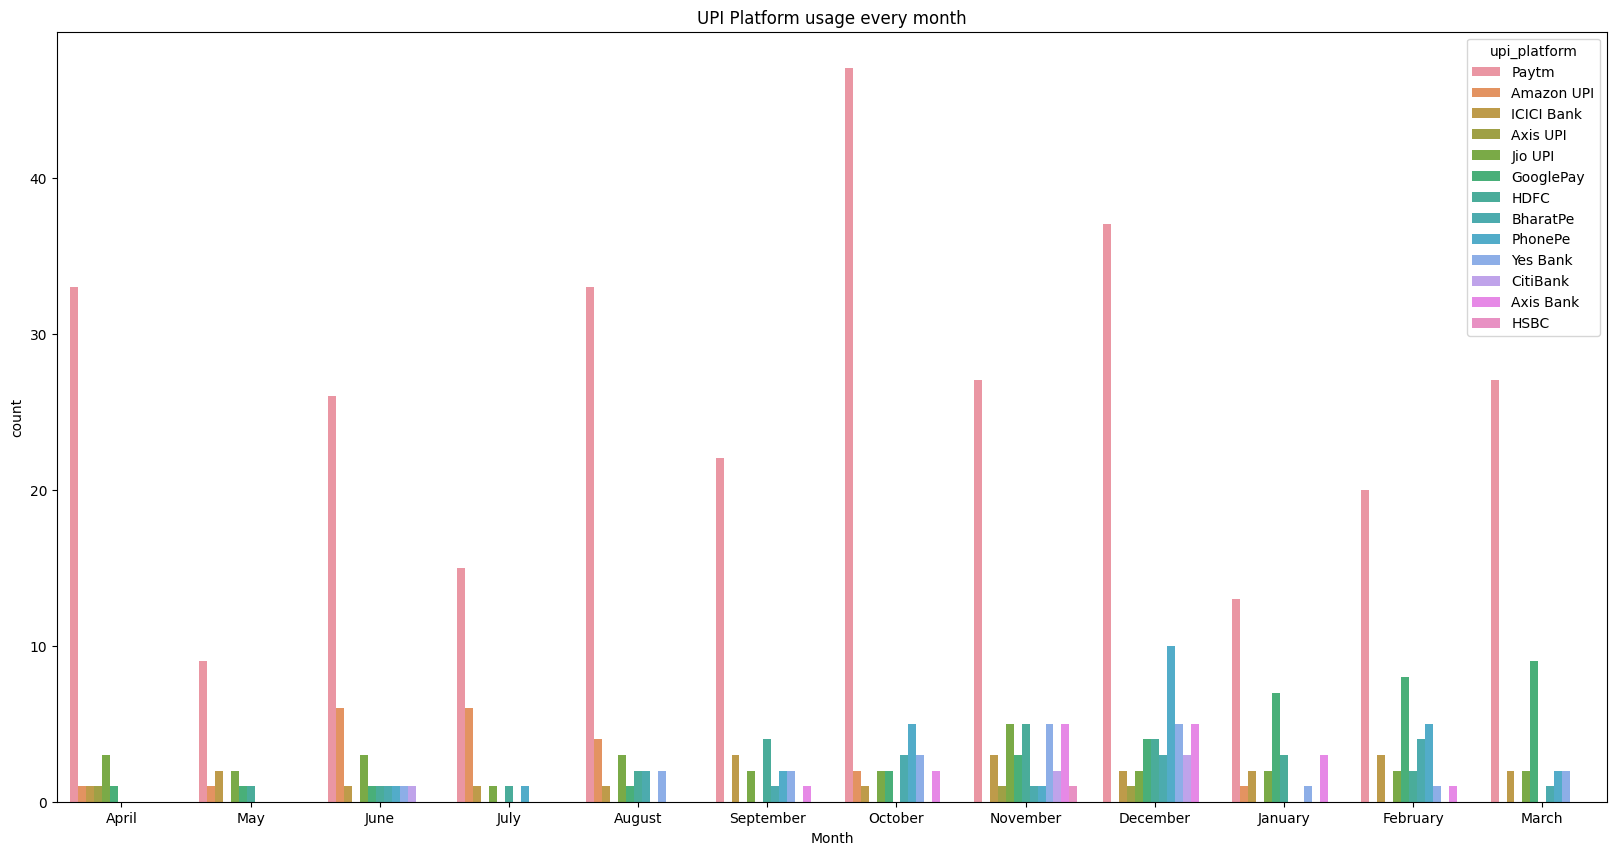

In [7]:
plt.figure(figsize=(20,10))
sns.countplot(x='Month',data=data,hue='upi_platform',order=months)
plt.title("UPI Platform usage every month")
plt.show();

## Expense Analysis

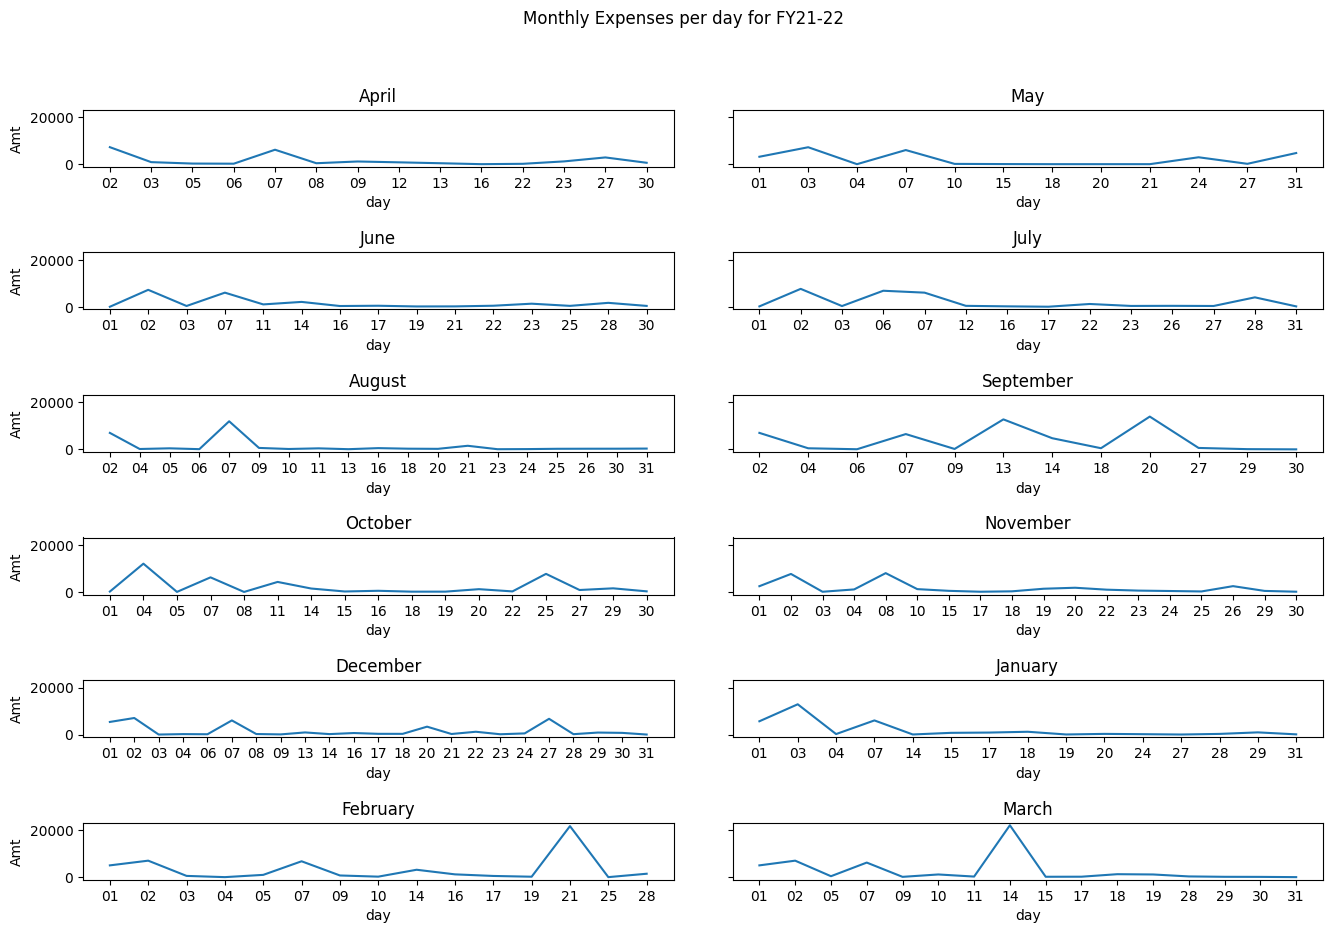

In [8]:
exp_df = data[expense_cols]

df = exp_df.groupby(["Transaction Date"])["Withdrawal Amount"].sum().reset_index()
df["day"] = df["Transaction Date"].dt.strftime('%d')
df['month'] = df["Transaction Date"].dt.month_name()

fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(16,10),sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=1.5)

for i,ax in enumerate(ax.flatten()):
    if i <= 12:        
        sns.lineplot(x='day', y='Withdrawal Amount',data=df[df["month"]==months[i]],ax=ax)
        ax.set_title(months[i])
        ax.set_ylabel("Amt")
    else:
        ax.set_visible(False)
        
plt.suptitle("Monthly Expenses per day for FY21-22")
plt.show()

---

What kind of expenses do I occur the most? <br>
- For this I will be binning the expenses into smaller bins
- Outliers will be removed

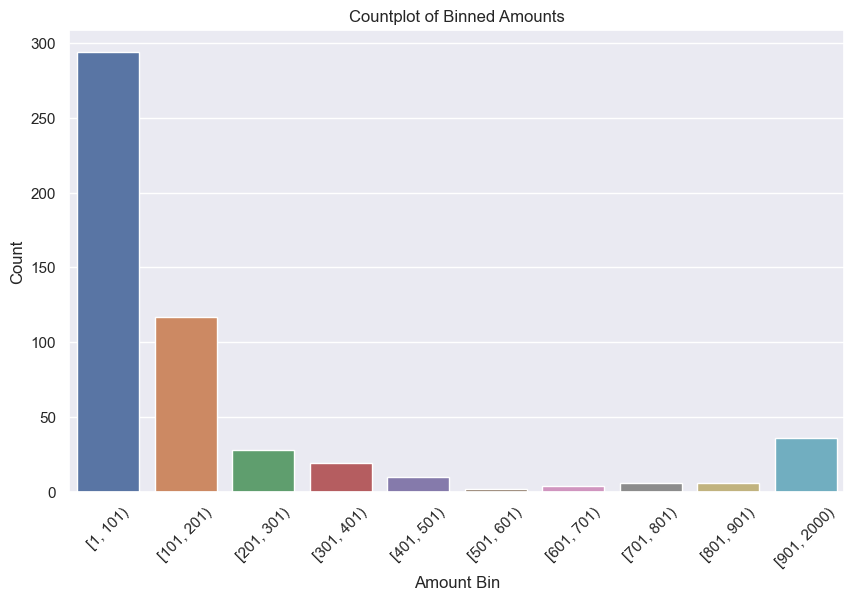

In [27]:
threshold = config.get("monthly_exp_threshold")
exclude_type = config.get("monthly_exp_type")
exp_df = data[expense_cols]

#Since my mutual funds investments are not really expenses, I will be removing them.
exp_df = exp_df[~exp_df["tnx_type"].isin(exclude_type)]

# Dropping amount 0 as these are credited values.
exp_df = exp_df[exp_df["Withdrawal Amount"] != 0]

# Since my monthly expenses rarely occur in large amounts, I have kept a threshold. Removing all the values beyond that.
exp_df = exp_df[exp_df["Withdrawal Amount"] <= threshold]


bin_edges = list(range(1,1000,100))
bin_edges.append(threshold) ## Adding the threshold value to the edge. This is to make sure to wrap up any outlier value in this bin.

# Bin the amounts
exp_df['Amount Bin'] = pd.cut(exp_df['Withdrawal Amount'], bins=bin_edges, right=False)

# Set the plot style
sns.set(style="darkgrid")
# Create the countplot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(data=exp_df, x='Amount Bin')

# Set the labels and title
plt.xlabel('Amount Bin')
plt.ylabel('Count')
plt.title('Count of different range of Expenditures')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)
# Show the plot
plt.show()

Since I do quite a bit of household shopping, I have a large number of small amount transactions.

---

### Investment Analysis

My investments are mostly of Mutual funds and my only source of income is my job 🥺

In [ ]:
amount_columns = ['Withdrawal Amount', 'Deposit Amount', 'Month']

# Filter the data for salary transactions
salary_data = data[data["tnx_type"] == "Salary"][amount_columns]
# Filter the data for investment transactions
investment_data = data[(data["tnx_type"] == "External MF") | (data["tnx_type"] == "Internal MF")][amount_columns]
# Calculate the monthly salary total
monthly_salary = salary_data.groupby(salary_data["Month"]).sum()["Deposit Amount"]
# Calculate the monthly investment total
monthly_investment = investment_data.groupby(investment_data["Month"]).sum()["Withdrawal Amount"]
# Combine the monthly salary and investment totals into a dataframe
investment_dataframe = pd.concat([monthly_salary, monthly_investment], axis=1)
investment_dataframe.columns = ["Salary", "Investment"]
investment_dataframe["inv_perc"] = round(investment_dataframe["Investment"] / investment_dataframe["Salary"], 3)
# Remove unnecessary months from the dataframe
investment_dataframe.drop(["April", "May"], inplace=True)
# Select the columns for the final dataframe
final_dataframe = investment_dataframe[["Salary", "Investment"]]
# Create a line plot of the salary and investment trends
plt.figure(figsize=(10, 5))
sns.lineplot(data=final_dataframe)
plt.xlabel('Month')
plt.ylabel('Values')
plt.title('Salary and Investment Trends')
plt.show()

---